# 1
Скачайте данные в формате csv, выберите из таблицы данные по России, начиная с 3 марта 2020 г. (в этот момент впервые стало больше 2 заболевших). В качестве целевой переменной возьмём число случаев заболевания (столбцы total_cases и new_cases); для упрощения обработки можно заменить в столбце new_cases все нули на единицы. Для единообразия давайте зафиксируем тренировочный набор в виде первых 50 отсчётов (дней), начиная с 3 марта; остальные данные можно использовать в качестве тестового набора (и он даже будет увеличиваться по мере выполнения задания).

In [208]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression

In [154]:
df = pd.read_csv('data/owid-covid-data.csv')

col = ['iso_code', 'date', 'total_cases', 'new_cases']
df = df.loc[:, col]

df = df[(df['iso_code'] == 'RUS') & (df['date'] >= '2020-03-03')]
df.new_cases[df.new_cases <= 0] = 1
df = df.reset_index(drop=True)
df.head(5)

,iso_code,date,total_cases,new_cases
0,RUS,2020-03-03,3.0,1.0
1,RUS,2020-03-04,3.0,1.0
2,RUS,2020-03-05,4.0,1.0
3,RUS,2020-03-06,13.0,9.0
4,RUS,2020-03-07,13.0,1.0


In [155]:
df_train = df[:50]
df_test = df[50:]
print(df_train.shape)
print(df_test.shape)

(50, 4)
(684, 4)


# 2
Постройте графики целевых переменных. Вы увидите, что число заболевших растёт очень быстро, на первый взгляд экспоненциально. Для первого подхода к снаряду давайте это и используем.

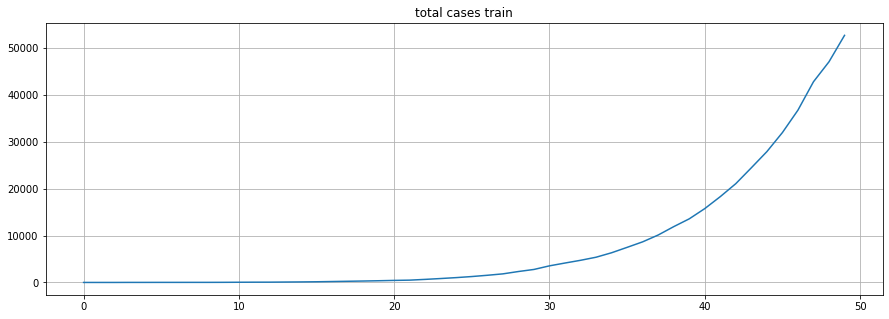

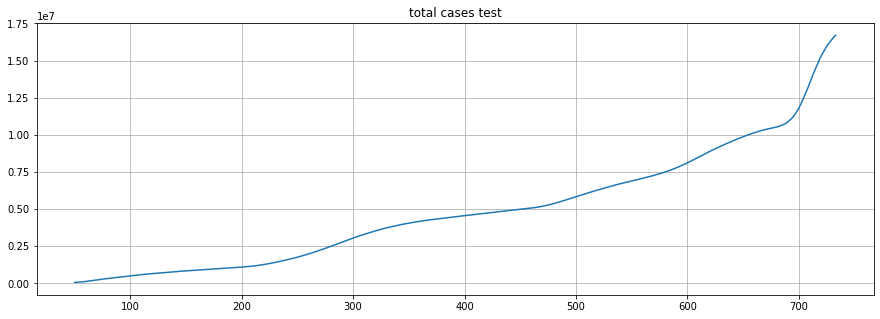

In [156]:
plt.figure(figsize=(15, 5))
plt.plot(df_train.index.values, df_train['total_cases'])
plt.grid()
plt.title('total cases train')

plt.figure(figsize=(15, 5))
plt.plot(df_test.index.values, df_test['total_cases'])
plt.grid()
plt.title('total cases test')
plt.show()

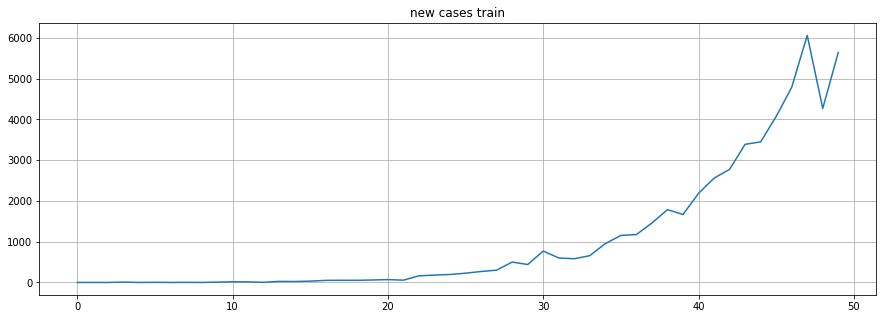

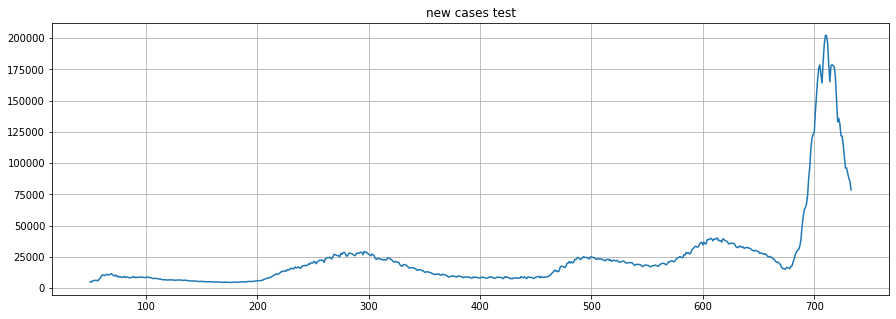

In [157]:
plt.figure(figsize=(15, 5))
plt.plot(df_train.index.values, df_train['new_cases'])
plt.grid()
plt.title('new cases train')

plt.figure(figsize=(15, 5))
plt.plot(df_test.index.values, df_test['new_cases'])
plt.grid()
plt.title('new cases test')
plt.show()

# 2.a
Используя линейную регрессию, обучите модель с экспоненциальным ростом числа заболевших: y ~ exp(линейная функция от x), где x — номер текущего дня.

In [158]:
X_train = df_train.index.values.reshape(-1, 1)
y_train = np.log(df_train['total_cases'])

model1 = LinearRegression()
model1.fit(X_train, y_train)
y_pred_train = model1.predict(X_train)

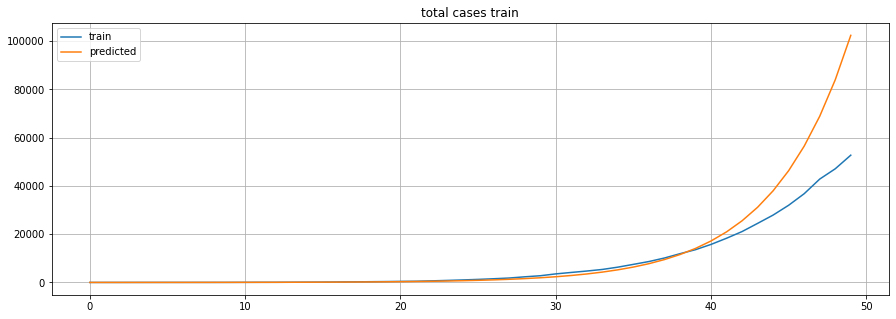

In [159]:
plt.figure(figsize=(15, 5))
plt.plot(X_train, np.exp(y_train), label='train')
plt.plot(X_train, np.exp(y_pred_train), label='predicted')
plt.title('total cases train')
plt.grid()
plt.legend()
plt.show()

# 2.b
Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели (это фактически первый шаг эмпирического Байеса).

In [160]:
sigma_noise = np.std(y_train - y_pred_train)
print(sigma_noise)

0.34904220596356583


In [161]:
def bayesian_update(mu_0, sigma_0, x, y, sigma_noise):
    x_ = np.concatenate((np.ones((len(x), 1)), x), axis=1)
    sigma_n = np.linalg.inv(np.linalg.inv(sigma_0) + (1 / sigma_noise ** 2) * np.dot(x_.T, x_))
    mu_n = np.dot(sigma_n, np.dot(np.linalg.inv(sigma_0), mu_0.T) + (1 / sigma_noise ** 2) * np.dot(x_.T, y))
    return mu_n, sigma_n

In [162]:
mu_0, sigma_0 = np.array([0, 0]), 100 * np.eye(2)
mu_n, sigma_n = bayesian_update(mu_0, sigma_0, X_train, y_train, sigma_noise)
print('mu_0:\n', mu_0, '\n')
print('mu_n:\n', mu_n, '\n')
print('sigma_0:\n', sigma_0, '\n')
print('sigma_n:\n', sigma_n)

mu_0:
 [0 0] 

mu_n:
 [1.8205655  0.19829611] 

sigma_0:
 [[100.   0.]
 [  0. 100.]] 

sigma_n:
 [[ 9.45888140e-03 -2.86632761e-04]
 [-2.86632761e-04  1.16995814e-05]]


# 2.c
Посэмплируйте много разных экспонент, постройте графики. Сколько, исходя из этих сэмплов, предсказывается случаев коронавируса в России к 1 мая? к 1 июня? к 1 сентября? Постройте предсказательные распределения (можно эмпирически, исходя из данных сэмплирования).

In [215]:
def exp_sample(x, w):
    return np.exp(w[0] + x * w[1])

n=300
w_samples = np.random.multivariate_normal(mu_n, sigma_n, size=n)
y_samples = [exp_sample(X_train.reshape(-1), w) for w in w_samples]

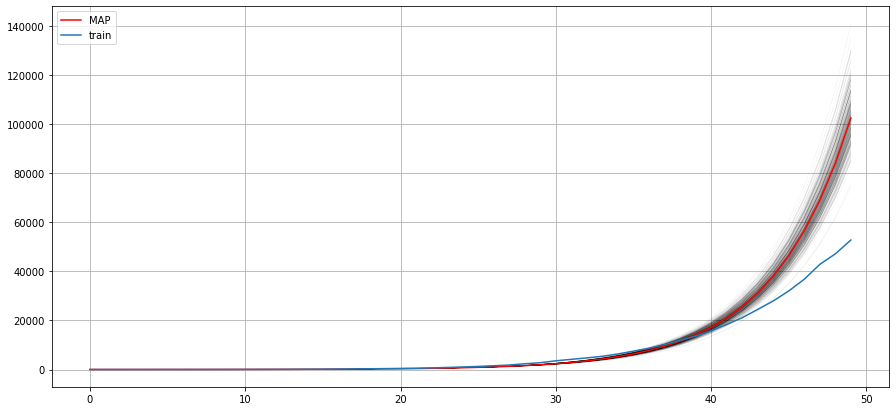

In [217]:
plt.figure(figsize=(15, 7))
for i in range(n):
    plt.plot(X_train, y_samples[i], color='k', alpha=0.3, linewidth=.1)

plt.plot(X_train, exp_sample(X_train, mu_n), label='MAP', c='r')
plt.plot(X_train, np.exp(y_train), label='train')
plt.grid()
plt.legend()
plt.show()

In [218]:
def predict_from_samples(day, w):
    y_i = df[df['date'] == day].index.values[0]
    return np.exp(w_samples.dot(np.array([[1], [y_i]])))

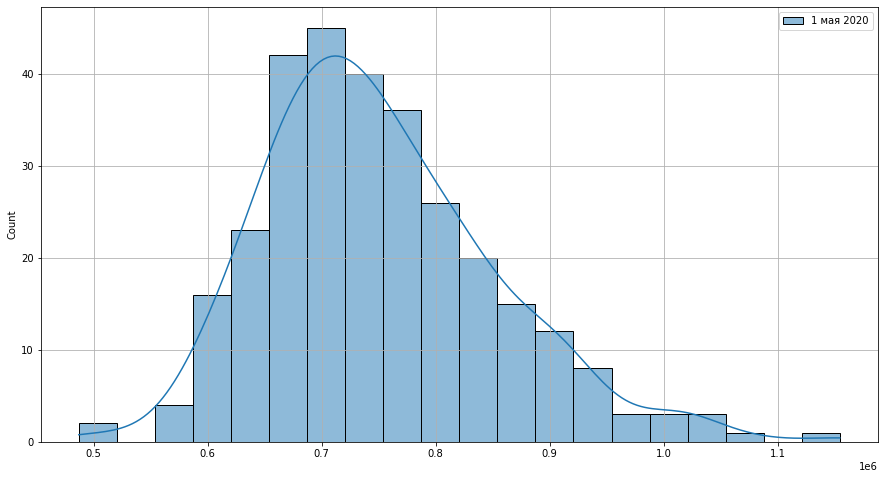

In [242]:
day = '2020-05-01'
pred1 = predict_from_samples(day, w_samples)

fig, ax = plt.subplots(figsize=(15, 8))
sns.histplot(pred1, ax=ax, bins=20, kde=True, label='1 мая 2020')
plt.legend()
plt.grid()
plt.show()

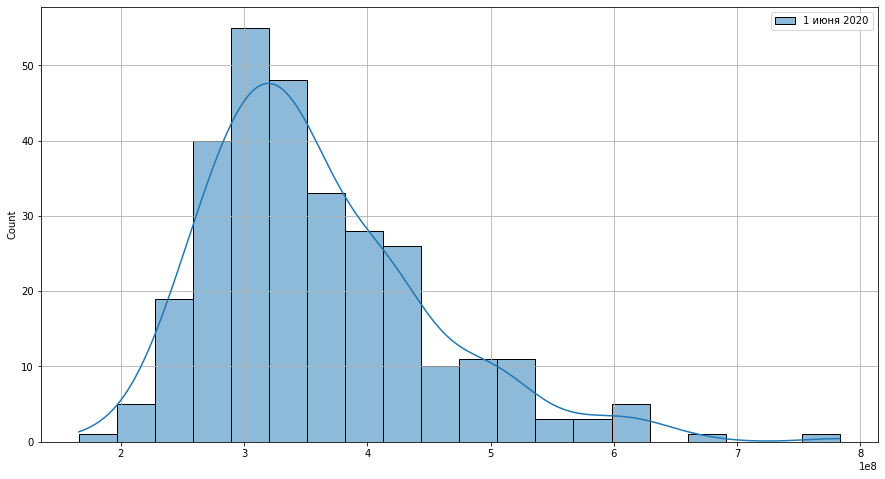

In [243]:
day = '2020-06-01'
pred2 = predict_from_samples(day, w_samples)

fig, ax = plt.subplots(figsize=(15, 8))
sns.histplot(pred2, ax=ax, bins=20, kde=True, label='1 июня 2020')
plt.legend()
plt.grid()
plt.show()

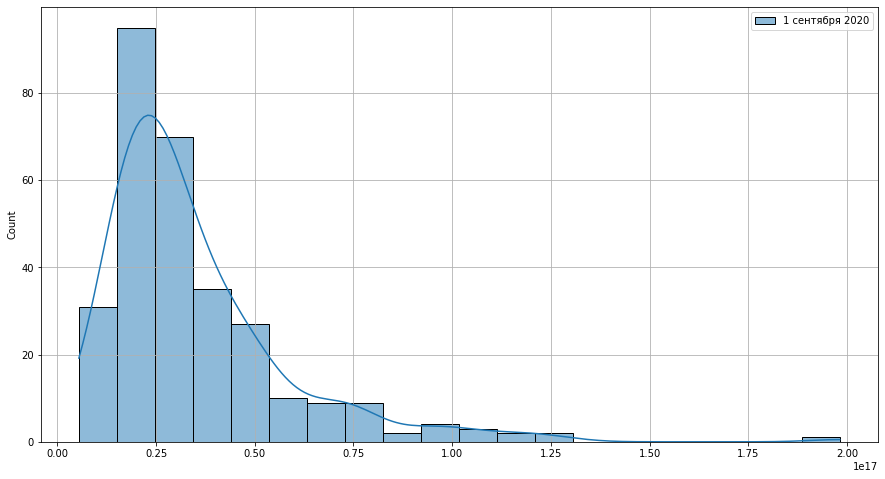

In [244]:
day = '2020-09-01'
pred3 = predict_from_samples(day, w_samples)

fig, ax = plt.subplots(figsize=(15, 8))
sns.histplot(pred3, ax=ax, bins=20, kde=True, label='1 сентября 2020')
plt.legend()
plt.grid()
plt.show()

In [246]:
print(f"Количество зараженных 1.05.2020: {int(np.mean(pred1))}")
print(f"Количество зараженных 1.06.2020: {int(np.mean(pred2))}")
print(f"Количество зараженных 1.09.2020: {int(np.mean(pred3))}")

Количество зараженных 1.05.2020: 750972
Количество зараженных 1.06.2020: 359484899
Количество зараженных 1.09.2020: 35043294844147780


# 3
Предсказания экспоненциальной модели наверняка получились грустными. Но это, конечно, чересчур пессимистично — экспоненциальный рост в природе никак не может продолжаться вечно. Кривая общего числа заболевших во время эпидемии в реальности имеет сигмоидальный вид: после начальной фазы экспоненциального роста неизбежно происходит насыщение. В качестве конкретной формы такой сигмоиды давайте возьмём форму функции распределения для гауссиана
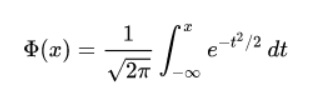
Естественно, в нашем случае сигмоида стремится не к единице, т.е. константа перед интегралом может быть произвольной (и её можно внести в экспоненту), а в экспоненте под интегралом может быть произвольная квадратичная функция от t.
## 3.a
Предложите способ обучать параметры такой сигмоидальной функции при помощи линейной регрессии.
$$y = w_0\cdot e^{w_1\cdot x + w_2\cdot x^2}$$
$$log(y) = w_0 + w_1\cdot x + w_2\cdot x^2$$
$$y \sim new\:cases$$
$$cumsum(y) \sim total \:cases$$

## 3.b
Обучите эти параметры на датасете случаев коронавируса в России. Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели.

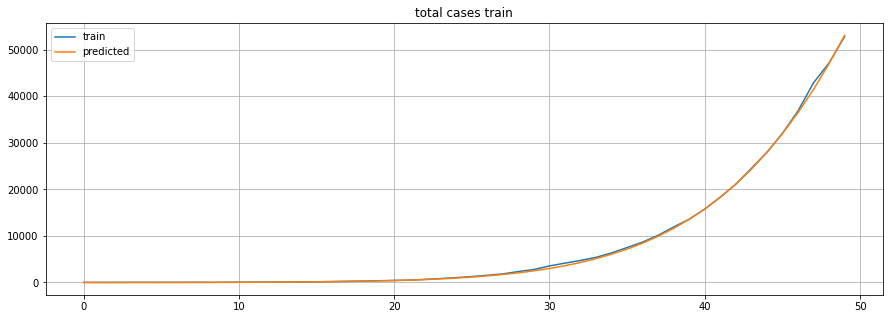

In [264]:
X = np.column_stack((X_train, X_train ** 2))
y = np.log(df_train['new_cases'])

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

plt.figure(figsize=(15, 5))
plt.plot(X_train, df_train['total_cases'], label='train')
plt.plot(X_train, np.cumsum(np.exp(y_pred)), label='predicted')
plt.title('total cases train')
plt.grid()
plt.legend()
plt.show()

In [267]:
sigma_noise = np.std(y - y_pred)
print(sigma_noise)

0.4891695424595195


In [270]:
mu_0, sigma_0 = np.array([0, 0, 0]), 100 * np.eye(3)
mu_n, sigma_n = bayesian_update(mu_0, sigma_0, X, y, sigma_noise)
print('mu_0:\n', mu_0, '\n')
print('mu_n:\n', mu_n, '\n')
print('sigma_0:\n', sigma_0, '\n')
print('sigma_n:\n', sigma_n)

mu_0:
 [0 0 0] 

mu_n:
 [-0.39642376  0.27560911 -0.00182956] 

sigma_0:
 [[100.   0.   0.]
 [  0. 100.   0.]
 [  0.   0. 100.]] 

sigma_n:
 [[ 3.97858000e-02 -3.21446447e-03  5.41155378e-05]
 [-3.21446447e-03  3.54467031e-04 -6.76539758e-06]
 [ 5.41155378e-05 -6.76539758e-06  1.38075588e-07]]


## 3.c
Посэмплируйте много разных сигмоид из апостериорного распределения, постройте графики. Сколько, исходя из этих сэмплов, будет всего случаев коронавируса в России? Постройте эмпирическое предсказательное распределение, нарисуйте графики. Каков ваш прогноз числа случаев коронавируса в пессимистичном сценарии (90-й процентиль в выборке числа случаев)? В оптимистичном сценарии (10-й процентиль)?

In [374]:
def exp_sample(x, w):
    return np.cumsum(np.exp(w[0] + x * w[1] + x ** 2 * w[2]))

n=300
w_samples = np.random.multivariate_normal(mu_n, sigma_n, size=n)
y_samples = [exp_sample(df[:190].index.values, w) for w in w_samples]

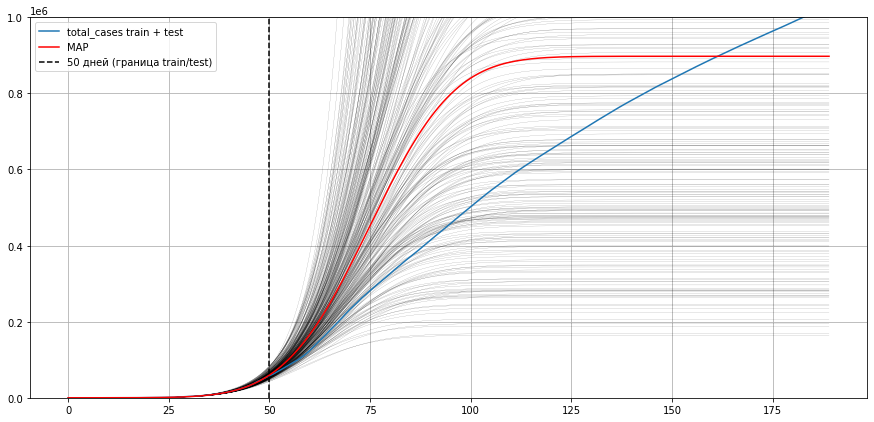

In [376]:
plt.figure(figsize=(15, 7))
for i in range(n):
    plt.plot(df[:190].index.values, y_samples[i], color='k', alpha=0.9, linewidth=.1)
    
plt.plot(df[:190].index.values, df[:190]['total_cases'], label='total_cases train + test')
plt.plot(df[:190].index.values, exp_sample(df[:190].index.values, mu_n), label='MAP', c='r')
plt.axvline(50, linestyle='--', c='k', label='50 дней (граница train/test)')
plt.grid()
plt.legend()
plt.ylim([0, 1e6])
plt.show()

In [386]:
def predict_from_samples(day, y_samples):
    y_i = df[df['date'] == day].index.values[0]
    return np.array([y_samples[i][y_i] for i in range(len(y_samples))])

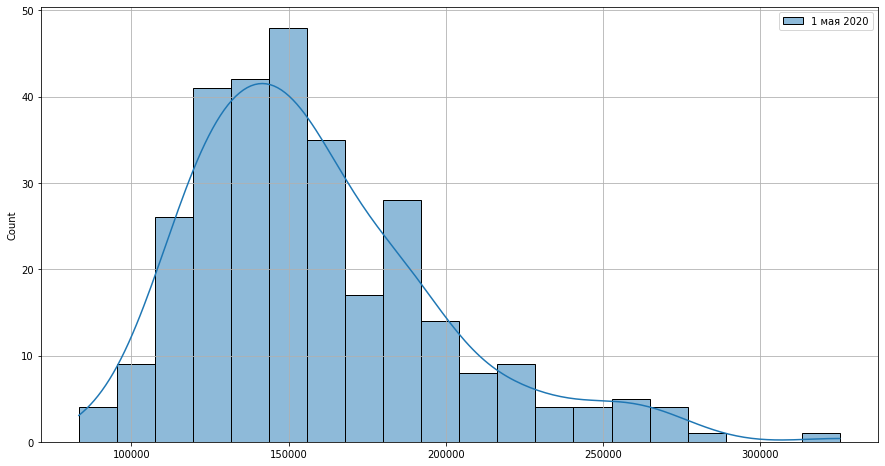

In [387]:
day = '2020-05-01'
pred1 = predict_from_samples(day, y_samples)

fig, ax = plt.subplots(figsize=(15, 8))
sns.histplot(pred1, ax=ax, bins=20, kde=True, label='1 мая 2020')
plt.legend()
plt.grid()
plt.show()

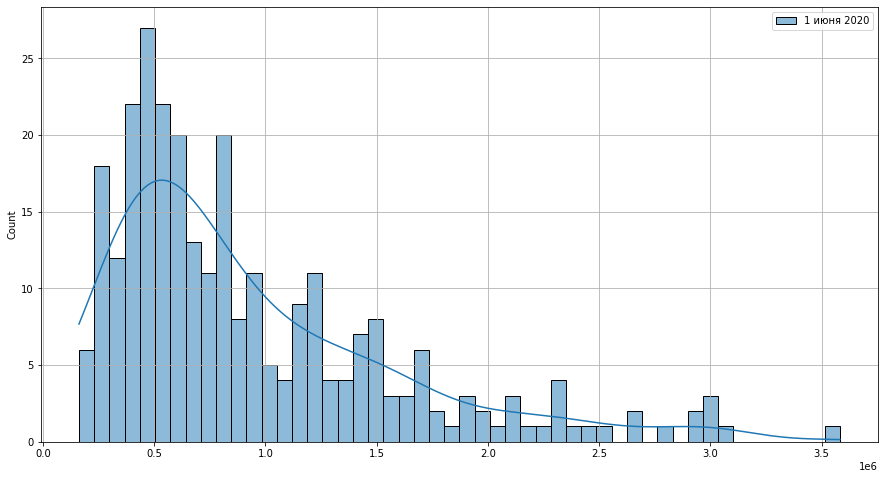

In [400]:
day = '2020-06-01'
pred2 = predict_from_samples(day, y_samples)

fig, ax = plt.subplots(figsize=(15, 8))
sns.histplot(pred2[pred2 < np.quantile(pred2, 0.95)], ax=ax, bins=50, kde=True, label='1 июня 2020')
plt.legend()
plt.grid()
plt.show()

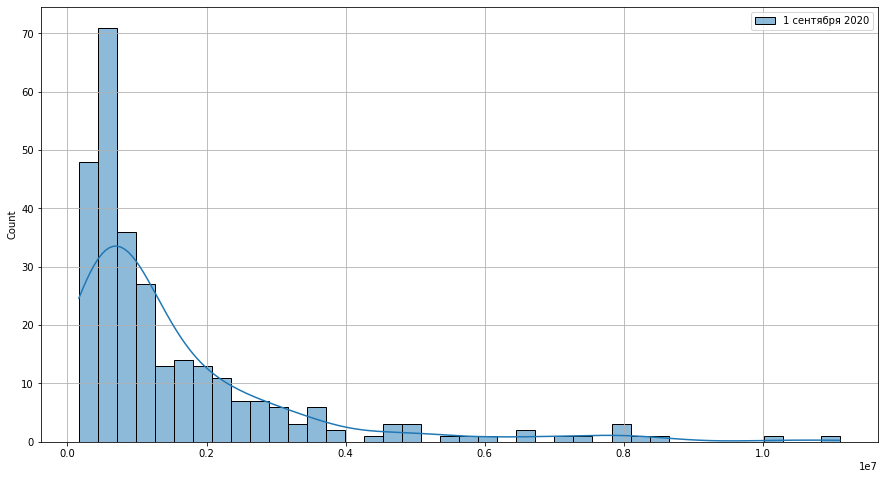

In [398]:
day = '2020-09-01'
pred3 = predict_from_samples(day, y_samples)

fig, ax = plt.subplots(figsize=(15, 8))
sns.histplot(pred3[pred3 < np.quantile(pred3, 0.95)], ax=ax, bins=40, kde=True, label='1 сентября 2020')
plt.legend()
plt.grid()
plt.show()

In [407]:
print(f"Количество зараженных 1.09.2020 (90-й процентиль): {int(np.quantile(pred3, 0.9))}")
print(f"Количество зараженных 1.09.2020 (10-й процентиль): {int(np.quantile(pred3, 0.1))}")
print(f"Количество зараженных 1.09.2020 (50-й процентиль): {int(np.quantile(pred3, 0.5))}")
print(f"Реальное количество зараженных 1.09.2020: {int(df['total_cases'][182])}")

Количество зараженных 1.09.2020 (90-й процентиль): 5028694
Количество зараженных 1.09.2020 (10-й процентиль): 348843
Количество зараженных 1.09.2020 (50-й процентиль): 946170
Реальное количество зараженных 1.09.2020: 997072


### В этот раз модель предсказала довольно близкий к реальным данным результат!